# What is the most optimal skill to learn for Data Analysts?
### Methodology
1. Group skills to determine median salary and likelihood of appearing in posting
2. Visualise median salary vs percent skill demand
3. Determine if certain technologiess are more commonplace

In [1]:
# Importing libraries
import ast
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import seaborn as sns

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # convert skill_list from str to list

In [2]:
# only interested in Data Analysts in the UK, so filter accordingly
df_da_uk = df[(df['job_title_short'] == 'Data Analyst') & (df['job_country'] == 'United Kingdom')].copy()

# drop any columns that conain NaN values for the yearly salary
df_da_uk = df_da_uk.dropna(subset=['salary_year_avg'])

In [3]:
# convert 'salary_year_avg' from usd to gbp, as we are studying data in the united kingdom
df_da_uk['salary_year_avg'] = df_da_uk['salary_year_avg'] * 0.77 # current exchange rate

In [4]:
# explode the dataframe on the 'job_skills' column so that each skill is its own row
df_da_uk_exploded = df_da_uk.explode('job_skills')

In [5]:
# group the data frame based on median salary and count, sort by count
df_da_skills = (df_da_uk_exploded.groupby('job_skills')['salary_year_avg']
                    .agg(['count', 'median'])
                    .sort_values(by='count', ascending=False))

In [6]:
# rename columns for clarity
df_da_skills = df_da_skills.rename(columns={'count': 'skill_count', 'median': 'median_salary'})

# convert the count of job postings to a percentage of skill mention. len(df_da_uk) is the total job postings. * 100 to convert to percent.
df_da_skills['skill_percent'] = (df_da_skills['skill_count'] / len(df_da_uk)) * 100

#investigate
df_da_skills

,skill_count,median_salary,skill_percent
job_skills,,,
sql,33,75845.000,45.833333
excel,29,58173.500,40.277778
python,25,68607.000,34.722222
tableau,13,77385.000,18.055556
r,9,59303.475,12.500000
...,...,...,...
gdpr,1,80850.000,1.388889
gcp,1,40820.780,1.388889
pyspark,1,75845.000,1.388889


In [7]:
# investigating shows there are 62 rows of data, so only include skills above a certain percentage threshold.
skill_percent = 5

df_da_skills_top = df_da_skills[df_da_skills['skill_percent'] > skill_percent]

# investigate -> now 16 rows, which is appropriate for a scatter plot. can easily be adjusted depending on results / taste.
df_da_skills_top

,skill_count,median_salary,skill_percent
job_skills,,,
sql,33,75845.000,45.833333
excel,29,58173.500,40.277778
python,25,68607.000,34.722222
tableau,13,77385.000,18.055556
r,9,59303.475,12.500000
go,9,54670.000,12.500000
sas,8,61605.390,11.111111
power bi,7,68607.000,9.722222
outlook,6,41469.890,8.333333


In [21]:
# want to colour code skills based on their associated technology
# select the appropriate column from our data frame, remove duplicates and NaN values
df_tech = df['job_type_skills'].drop_duplicates().dropna().copy()

# combine all the dictionaries
tech_dict = {}
for row in df_tech:
    row_dict = ast.literal_eval(row) # convert string to dictionary
    for key, value in row_dict.items():
        if key in tech_dict: # if the key already exists, add the value to the existing key
            tech_dict[key] += value
        else:                # else the key does not already exist, so set value to key
            tech_dict[key] = value
# remove duplicates, convert to set then back to list
for key, value in tech_dict.items():
    tech_dict[key] = list(set(value))

In [33]:
# convert dictionary into a dataframe assigning columns
df_tech = pd.DataFrame(list(tech_dict.items()), columns=['Technology', 'skills'])

# explode the skills column, so each skill is its own row
df_tech = df_tech.explode('skills')

In [34]:
# merge with our 'df_da_skills_top' data frame
df_plot = df_da_skills_top.merge(df_tech, left_on='job_skills', right_on='skills')

# investigate
df_plot

,skill_count,median_salary,skill_percent,Technology,skills
0,33,75845.000,45.833333,programming,sql
1,29,58173.500,40.277778,analyst_tools,excel
2,25,68607.000,34.722222,programming,python
3,13,77385.000,18.055556,analyst_tools,tableau
4,9,59303.475,12.500000,programming,r
5,9,54670.000,12.500000,programming,go
6,8,61605.390,11.111111,analyst_tools,sas
7,8,61605.390,11.111111,programming,sas
8,7,68607.000,9.722222,analyst_tools,power bi
9,6,41469.890,8.333333,analyst_tools,outlook


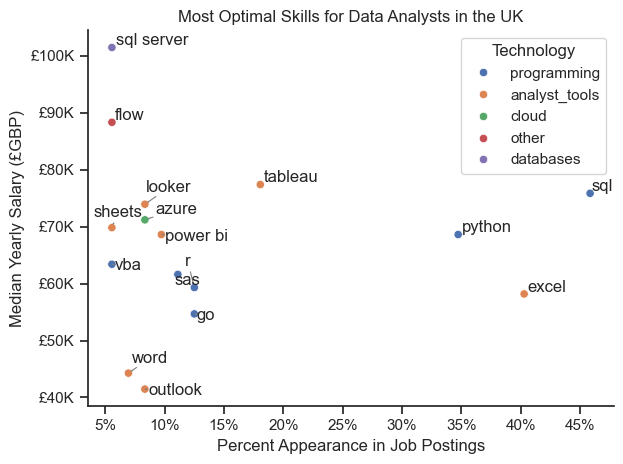

In [36]:
from adjustText import adjust_text # a module for adjusting text
import matplotlib.ticker as mticker

# plot the data using 'Technology' column as the hue - technology was the key in our dict, so represents non-repeated technologies. capital T for legend().
sns.scatterplot(
    data=df_plot,
    x='skill_percent',
    y='median_salary',
    hue='Technology'
)

# aesthetic changes
sns.despine()
sns.set_theme(style='ticks')

# add texts of the technologies, placed in optimal positions
texts = [] # create an empty list for the arg in adjust_text
for i, txt in enumerate(df_da_skills_top.index):
    texts.append(plt.text(df_da_skills_top['skill_percent'].iloc[i], df_da_skills_top['median_salary'].iloc[i], txt)) # append everything to 'texts'

adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=.8)) # adjusts texts, add arrows

# set the axes to percent and GBP
ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'£{int(y/1000)}K'))

# add labels
plt.xlabel('Percent Appearance in Job Postings')
plt.ylabel('Median Yearly Salary (£GBP)')
plt.title('Most Optimal Skills for Data Analysts in the UK')

# tight layout and show
plt.tight_layout()
plt.show()